# Lab 08 - Convolutional Neural Networks

By Erik Gabrielsen, Danh Nguyen, and Conrad Appel

## Business Understanding

In this lab, we are interested in investigating image processing techniques and seeing how well these techniques will work with our custom multilayer perceptron and scikit-learn's. We will be using the CIFAR-10 small images (32x32) dataset, which contains the following labels:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

The goal is to have the models predict as well as possible according to the F1 score, since we are interested in seeing how correctly images are classified. The highest score based on accuracy on Kaggle is around .96, but that requires hours and hours of computation time. If we can perform image recognition anywhere near as well with a relatively simple model to implement, then perhaps we have good processing techniques. This project has computer vision applications, and could be applied to robotics and especially people that wants to deploy simple image recognition models without access to large computationally expensive servers. Ideally, we would want our F1 score to be around 90%, so that the majority of images can be accomplished by the computer with some checks by people, but are aiming around 70% with high categorical accuracy to determine if there are some objects we can distinguish without going through days of training

In [1]:
from keras.datasets import cifar10
from keras.models import Sequential, Input, Model
from keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import keras
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import metrics as mt
import numpy as np
print(keras.__version__)

Using TensorFlow backend.


2.0.3


## Preparation 

In our Cifar dataset, we one-hot-encoded the categorical label (y) of our 10 classes. For the first network, we kept the images as 3 color layers of 32x32 pixels, but we applied random rotations to the images for data augmentation.

In [2]:
l2_lambda = 0.0001

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
NUM_CLASSES = 10
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.
)
datagen.fit(x_train)

## Metrics

### Scoring
We need to choose a method for scoring our classifier, out of accuracy, recall, precision, and F-score. For a start, let's define the four possible cases when classifying an image:
* True Positive: Image is of class X, and we correctly guessed class X.
* True Negative: Image is of class X, and we correctly stated that it wasn't any of the other 9 classes. In our cases, a True Positive also comes with the benefit of having 9 True Negatives.
* False Positive: Image is of class X, and we incorrectly guessed class Y.
* False Negative: Image is of class X, and we didn't guess that it was X. Like the True Negative, if we have a False Positive, we also have a False Negative.

We use categorical accuracy to interpret our confusion matrices and ROC curves. To score our models -- because the True Positives and True Negatives are all paired up with each other -- it would be safe to say that we only need to maximize one of them, as maximizing one intrinsically maximizes the other. As such, we can eliminate accuracy score, because we don't need to account for both. Additionally, because having a False Positive means we have a False Negative paired with it, we can weight each equally. We also want to minimize both False Positives and False Negatives. The only scoring method left that takes all these attributes into account is the F-score. In our case, we use the F1 score, as we want to weigh False Positives and Negatives equally. Since Keras removed the f1 scores in their latest version, we reimplemented them as a custom function to pass into our model. 


### Cross-Validation
We also needed to choose a method for splitting our data set into smaller sets that more closely model a real-life scenario, as we don't get to train over every sample of data that comes in before needing to predict what its outcome will be. We have a couple of tools in our arsenal for cross-validation: simple train-test splits, K-folds, shuffle splits, and stratified K-fold or shuffle splits. Coming into the problem, there are a few properties of our dataset that we can use when making this decision. First off, we know that our set is perfectly balanced - there are exactly 6000 members of each class in the combined datasets. Secondly, there is no need for any ordering of our set as it's not a time-series or any other ordered series. Lastly, there shouldn't be any bias in the ordering of members of a class. Because of these three characteristics, we believe that we could reliably pick any of the aforementioned techniques and still get good results. However, some of the techniques are intrinsically better than the others. In the interest of time, we use 2 splits of a shuffle split to train our data and perform our graph calculations with the testing data provided by the Cifar dataset.

In [3]:
# from keras version < 2.0 https://github.com/fchollet/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7#diff-7b49e1c42728a58a9d08643a79f44cd4L134
from keras import backend as K
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batcwise average of precision.

    Computes the precision, a metric for multlabel classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batcwise average of recall.

    Computes the recall, a metric for multlabel classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
 
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batchwise average, not globally.

    This is useful for multilabel classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The Fbeta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.

    With beta = 1, this is equivalent to a Fmeasure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

 
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

In [4]:
# pretty confusion matrices

from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    f1 = mt.f1_score(y_test,yhat, average="macro")
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'F1: {:.4f}'.format(f1)+' Acc: {:.4f}'.format(acc))
    

In [5]:
def plot_roc(probas, y_true):
    plt.figure(figsize=(15,5))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    classes = np.unique(y_true)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    for j in classes:
        fpr, tpr, thresholds = mt.roc_curve(y_true, probas[:, j], pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += mt.auc(fpr, tpr)
        plt.plot(fpr,tpr,'--',lw=.5,label='Class ROC for ensemble, AUC=%0.4f'
                     %(mt.auc(fpr, tpr)) )

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr

    plt.plot(mean_fpr,perclass_mean_tpr,'-',lw=2,label='Mean Class ROC for ensemble, AUC=%0.4f'
                     %(roc_auc))
    plt.legend(loc='best')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve')
    

In [7]:
from scipy.misc import imresize

x_train_up = [imresize(x,size=(64,64,3), interp='bicubic') for x in x_train]
x_train_up = np.stack(x_train_up,axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x,size=(64,64,3), interp='bicubic') for x in x_test]
x_test_up = np.stack(x_test_up,axis=0)
print(x_test_up.shape)

(50000, 64, 64, 3)
(10000, 64, 64, 3)


## Modeling 

### LeNet

For our first Convolutional Neural Network, we chose to adapt the LeNet model (created by and named after Yann LeCun). The LeNet is charactarized by 5 main layers: 3 2-dimensional convolution layers, with 2 2-dimensional max pooling layers inbetween. It was originally created to classify handwritten numbers from 0-9, but we've repurposed the generic nature of the CNN to use on the CIFAR-10 dataset. We achieved the best results using 6 5x5px filters, followed by 16 5x5 filters, followed by 120 1x1 filters. Overall, this set-up gave us about a 63% F1 score on our test set.

In [13]:
%%time
# build model
lenet = Sequential()
lenet.add(Conv2D(filters=6,kernel_size=(5,5),
               input_shape = (32,32,3), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
lenet.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
lenet.add(Conv2D(filters=16,kernel_size=(5,5), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
lenet.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
#lenet.add(Dropout(0.5))
lenet.add(Conv2D(filters=120,kernel_size=(1,1), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))

lenet.add(Flatten())
lenet.add(Dense(84))
lenet.add(Activation("sigmoid"))
lenet.add(Dense(NUM_CLASSES))
lenet.add(Activation('softmax'))
lenet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy', fmeasure])

# the flow method yields batches of images indefinitely, with the given transformations
cv = StratifiedShuffleSplit(n_splits=2, test_size=.2)
for train_index, test_index in cv.split(x_train, y_train_ohe):
    lenet.fit_generator(datagen.flow(x_train[train_index], y_train_ohe[train_index], batch_size=128), 
      steps_per_epoch=int(len(x_train[train_index])/128), # how many generators to go through per epoch
      epochs=25, verbose=2,
      validation_data=(x_train[test_index],y_train_ohe[test_index]),
      callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
     )

Epoch 1/25
23s - loss: 1.8145 - acc: 0.3538 - fmeasure: 0.1297 - val_loss: 1.7355 - val_acc: 0.3857 - val_fmeasure: 0.1976
Epoch 2/25
22s - loss: 1.5239 - acc: 0.4609 - fmeasure: 0.3169 - val_loss: 1.4968 - val_acc: 0.4739 - val_fmeasure: 0.3589
Epoch 3/25
23s - loss: 1.4340 - acc: 0.4980 - fmeasure: 0.3818 - val_loss: 1.4166 - val_acc: 0.5066 - val_fmeasure: 0.4209
Epoch 4/25
23s - loss: 1.3736 - acc: 0.5170 - fmeasure: 0.4216 - val_loss: 1.4979 - val_acc: 0.4874 - val_fmeasure: 0.4044
Epoch 5/25
23s - loss: 1.3269 - acc: 0.5377 - fmeasure: 0.4482 - val_loss: 1.3786 - val_acc: 0.5182 - val_fmeasure: 0.4074
Epoch 6/25
22s - loss: 1.2894 - acc: 0.5492 - fmeasure: 0.4731 - val_loss: 1.4813 - val_acc: 0.5086 - val_fmeasure: 0.4507
Epoch 7/25
22s - loss: 1.2579 - acc: 0.5601 - fmeasure: 0.4897 - val_loss: 1.3163 - val_acc: 0.5516 - val_fmeasure: 0.5000
Epoch 8/25
23s - loss: 1.2304 - acc: 0.5713 - fmeasure: 0.5116 - val_loss: 1.1841 - val_acc: 0.5924 - val_fmeasure: 0.5327
Epoch 9/25
23s -

Our LeNet F1 is not as high as we would have liked for our business case. As the confusion matrix below displays, the model has trouble classifying a number of classes correctly, such as 4, 5, 7 and 9, but the model is not classifying everything into one or two classes. Our ROC curves and mean AUC of about .94 show that we have a good trade off between our true positive and false positive scores, but we need to improve our true positive scores. However, the model does generally appear to do better with more epochs, and perhaps with more training the network can improve even more.

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


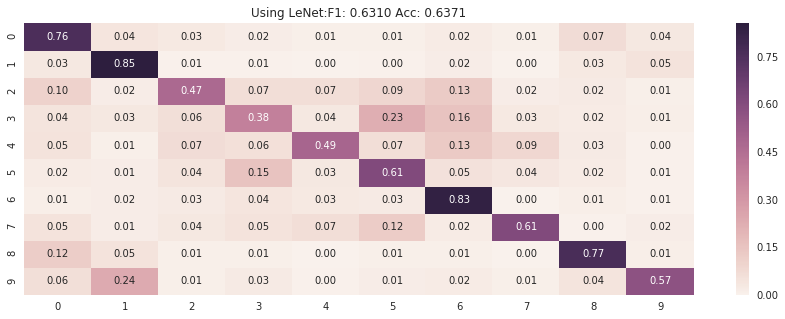

In [14]:
summarize_net(lenet, x_test, y_test, title_text='Using LeNet:')

 9984/10000 [============================>.] - ETA: 0s

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


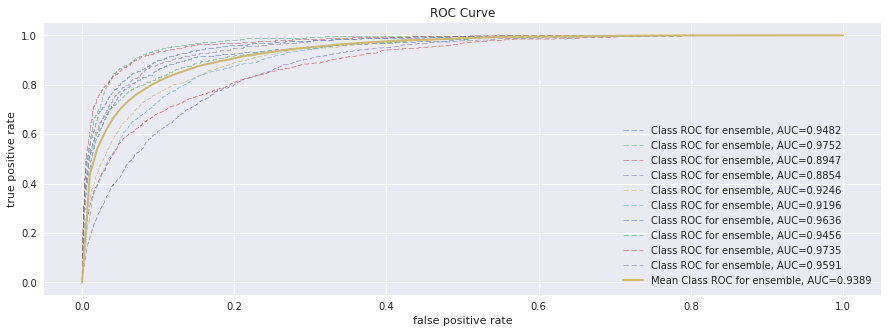

In [15]:
probas = lenet.predict_proba(x_test)
plot_roc(probas, y_test)

We attempted to view the convolutional layers, but unfortunately there are no clear distinguishing features we can draw from them. The last layer especially appear to not be very helpful in picking out certain traits. 

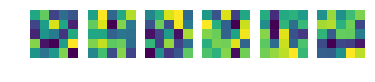

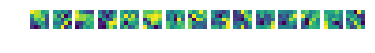

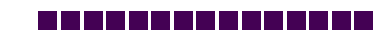

In [6]:
max_plots = 15
for layer in lenet.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
        plt.show()


## Simple CNN model

This CNN model is based off of an implementation by Jason Brownlee. In this deep neural network we will add the the following layers:

   * Convolutional input layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
   * Dropout layer at 20%.
   * Convolutional layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
   * Max Pool layer with size 2×2.
    
We repeat these layers for 32, 64, and 128, then finished by adding another Dropout layer at 20% and a fully connected layer with units and a relu/softmax activation function repeated 3 times for 1024, 512, and 10 units.

We then train the data by first doing a stratified split of 2 with a test size of .2, a learning rate of .01 and a max of 25 epochs. 

Below is a printed out summary of the model and the results.

In [77]:
# Simple CNN model for CIFAR-10
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', fmeasure])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 16, 16)        36928     
__________

We ran the functions in a separate notebook on a separate server, the graphs and results below are images taken from said notebooks. 

In [78]:
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

cv = StratifiedShuffleSplit(n_splits=2, test_size=.2)
for train_index, test_index in cv.split(X_train, y_train):
    model.fit(X_train[train_index], y_train[train_index], validation_data=(X_train[test_index], y_train[test_index]), epochs=epochs, batch_size=64)
    # Final evaluation of the model
    scores = model.evaluate(X_train[test_index], y_train[test_index], verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 184s - loss: 2.0081 - acc: 0.2607 - fmeasure: 0.0507 - val_loss: 1.7750 - val_acc: 0.3634 - val_fmeasure: 0.0565
Epoch 2/25
40000/40000 [==============================] - 171s - loss: 1.6162 - acc: 0.4061 - fmeasure: 0.2401 - val_loss: 1.4573 - val_acc: 0.4684 - val_fmeasure: 0.2904
Epoch 3/25
40000/40000 [==============================] - 159s - loss: 1.4097 - acc: 0.4857 - fmeasure: 0.3802 - val_loss: 1.2837 - val_acc: 0.5417 - val_fmeasure: 0.4098
Epoch 4/25
40000/40000 [==============================] - 154s - loss: 1.2652 - acc: 0.5409 - fmeasure: 0.4681 - val_loss: 1.1756 - val_acc: 0.5817 - val_fmeasure: 0.4992
Epoch 5/25
40000/40000 [==============================] - 158s - loss: 1.1569 - acc: 0.5833 - fmeasure: 0.5327 - val_loss: 1.1266 - val_acc: 0.5977 - val_fmeasure: 0.5449
Epoch 6/25
40000/40000 [==============================] - 159s - loss: 1.0604 - acc: 0.6200 - f

KeyboardInterrupt: 

Using this network, we were able to optain an F1 score of .7554 and an accuracy of .7564 after training on our CNN model for 25 epochs, taking approximately 2.5 hours on the SMU Genuse Machines. These results are better than any network and MLP we have applied in the past. While we have attempted quite a few different techniques (detailed in the sections below), the deeper layers, Relu activations, and use dropout may explain why this model is performing much better than our previous LeNet.

The matrix shows that all classes are predicted correctly most of the time, and our almost too-good ROC curve shows that we have a good trade-off and a mean AUC of about .97. 

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

summarize_net(model, X_test, y_test, title_text='Using Basic CNN')

![matrix](https://raw.githubusercontent.com/egabrielsen/MachineLearning/master/Lab08/confmat.png)


In [ ]:
probas = model.predict_proba(X_test)
plot_roc(probas, y_test)

![matrix](https://raw.githubusercontent.com/egabrielsen/MachineLearning/master/Lab08/roc.png)


Unfortunately, graph of the convolutional layers also does not provide a human-friendly understanding, but it appears that all kernels are distinguishing different features. 

In [ ]:
max_plots = 15
for layer in model.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
        plt.show()

![convolve](https://raw.githubusercontent.com/egabrielsen/MachineLearning/master/Lab08/layers.png)

## MLP

We implemented a scikit-learn MLP from our previous labs to compare our results. In lab 5, we created a flattened, black and white image from each cifar image and applied a daisy filter. We trained an MLP on top of the layer with two splits. The results are not as comparable to neural networks we implemented. While the AUC indicates that this model is better than random chance, it is not as great as the neural networks. The MLP F1 score and accuracy is also not as comparable as the neural networks, and the model has difficulty with classes 2, 3, and 5 in particular.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import _pickle as cPickle
import os
from skimage.feature import daisy

In [7]:
###
# Download dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# save all files to ./imgs/
###

def get_images(): # stuck this in a function to clean up memory 
    dics = []
    for root, directory, files in os.walk('imgs'):
        for f in files:
            if 'data_batch' in f or 'test_batch' in f:
                with open(root+'/'+f, 'rb') as fo:
                    dics.append(cPickle.load(fo, encoding='latin1'))

    img_color = []
    img_labels = []
    for dic in dics:
        for i in range(len(dic['data'])):
            img_color.append(dic['data'][i]) # 1D img (1024 R, 1024 G, 1024 B)
            img_labels.append(dic['labels'][i]) # int representing the label

    img_color = np.array(img_color)
    img_labels = np.array(img_labels)

    # grab the mapping between label names and IDs
    print('Labels:')
    labels = {}
    with open('./imgs/batches.meta', 'rb') as fo:
        labels_tmp = cPickle.load(fo, encoding='latin1')
        for i in range(len(labels_tmp['label_names'])):
            labels[i] = labels_tmp['label_names'][i]
            print(i, "-->", labels_tmp['label_names'][i])
    print()

    img_label_names = np.array([labels[x] for x in img_labels])

    def toGrayscale(img):
        r, g, b = img[:1024], img[1024:2048], img[2048:]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

    img_gray = np.array([toGrayscale(x) for x in img_color])
    
    return (img_color, img_gray, img_labels, img_label_names)

img_color, img_gray, img_labels, img_label_names = get_images()
img_gray = img_gray
img_labels = img_labels
print("n_samples: {}".format(len(img_gray)))
print("n_features: {}".format(len(img_gray[0])))
print("n_classes: {}".format(len(np.unique(img_labels))))
print("Original Image Size: {} x {}".format(32, 32))

Labels:
0 --> airplane
1 --> automobile
2 --> bird
3 --> cat
4 --> deer
5 --> dog
6 --> frog
7 --> horse
8 --> ship
9 --> truck

n_samples: 60000
n_features: 1024
n_classes: 10
Original Image Size: 32 x 32


In [8]:
daisies = np.array([np.concatenate(np.concatenate(daisy(x.reshape((32,32)), step=16, radius=7, rings=2, histograms=8, orientations=5))) for x in img_gray])

In [9]:
# SKLearn's implementation
x = daisies
y = img_labels
cv = StratifiedShuffleSplit(n_splits=2, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('TLP', MLPClassifier())])
for train_index, test_index in cv.split(x, y):
    pl.fit(x[train_index], y[train_index])
    yhat_mlp = pl.predict(x[test_index])
    print('f1 score:', mt.f1_score(y[test_index], yhat_mlp, average='macro'))
    print(np.bincount(yhat_mlp))

f1 score: 0.57630739397
[1275 1203 1171 1119 1251 1078 1328 1216 1179 1180]
f1 score: 0.58119322678
[1263 1224 1136  998 1320 1206 1204 1348 1150 1151]


/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


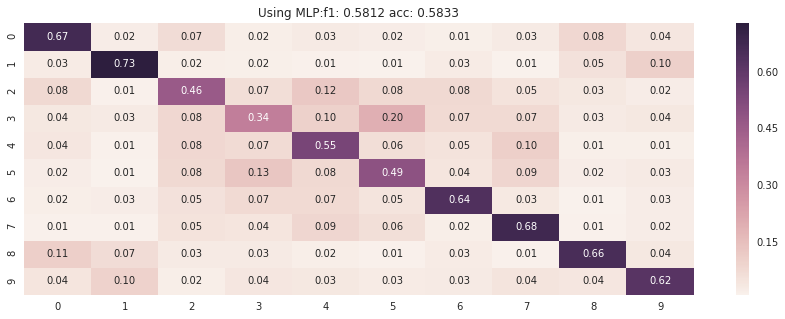

In [10]:
plt.figure(figsize=(15,5))
cm = mt.confusion_matrix(y[test_index],yhat_mlp)
cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
acc = mt.accuracy_score(y[test_index],yhat_mlp)
f1 = mt.f1_score(y[test_index],yhat_mlp, average="macro")
sns.heatmap(cm, annot=True, fmt='.2f')
plt.title("Using MLP:"+'f1: {:.4f}'.format(f1)+' acc: {:.4f}'.format(acc))

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


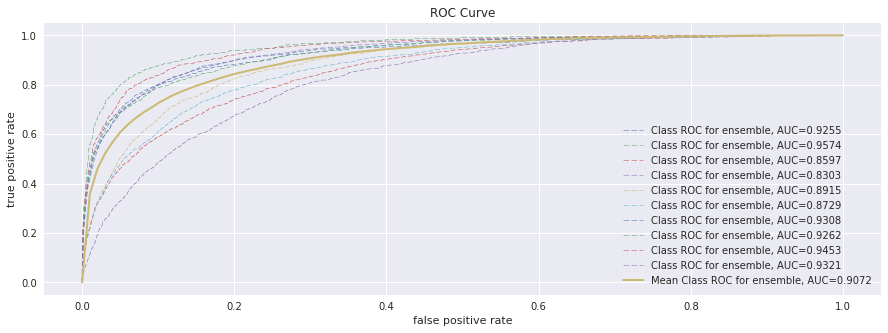

In [11]:
probas = pl.predict_proba(x[test_index])
plot_roc(probas, y[test_index])

## Other Attempted Techniques

* Larger image size

The idea behind using a larger image size was that each pixel would contain more specific spatial information about specific features in the image. For example, at our original size of 32x32px images, a single pixel might potentially contain the entire eye of a cat. If we upsample and interpolate the image (by using bicubic interpolation, for example), we would have hopefully been able to achieve more specific filters that would hopefully help us more effectively classify images. We tried this technique by upscaling to 64x64 and 128x128px, but neither gave us better results. At the same time, increasing the image sizes exponentially increased runtime of training, as expected. We believe there still may be potential for this technique, but we scrapped it for this lab.

* Larger/smaller filter kernel size

Just as increasing the image size should theoretically give us a better ability to classify using more minute details, changing filter size should also give us an improved ability to generalize. Larger kernel sizes would be more useful for general patterns in the image, and smaller kernels would help us identify more minute details. We tried a few different sets of kernel sizes, but we also didn't have better luck with this technique, unfortunately.

* Affine transformations

The idea behind preprocessing images with affine transformations is to get a fully general idea of the images. For example, pictures of the same subject might be taken from different angles or orientations. Even if we don't recieve these different images in the training set, we can mock them by performing flips, shears, rotations, and more. We expected these transformations to have a negative effect in the short-term, especially when calculating loss over the training set during the process. However, we never saw the long-term generalization benefits when testing on the validation set as we expected.